In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

In [2]:
# rotation matrix
Rx = lambda theta: np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]])
Ry = lambda theta: np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]])
Rz = lambda theta: np.array([
    [np.cos(theta), -np.sin(theta), 0], 
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]])

# skew symmetric matrix for cross product
skew = lambda v: np.array([
    [0, -v[2], v[1]],
    [v[2], 0, -v[0]],
    [-v[1], v[0], 0]])    

In [3]:
class Arrow:

    def __init__(self, start, end, color='black', name=None):
        start = start.flatten()
        end = end.flatten()
        head_scale = 0.3 # adjusts the cone size scaling 

        body = go.Scatter3d(x = [start[0], end[0]],
                            y = [start[1], end[1]],
                            z = [start[2], end[2]], 
                            mode = "lines",
                            line = dict(color=color), 
                            showlegend = False)
        
        head = go.Cone(x = [end[0]], y = [end[1]], z = [end[2]],
                    u = [end[0]-start[0]], v = [end[1]-start[1]], w = [end[2]-start[2]],
                    sizemode = "scaled",
                    sizeref = head_scale,
                    colorscale = [[0, color], [1, color]],
                    showscale=False,
                    showlegend=False)
        
        dist = 0.4
        text = go.Scatter3d(x = [-dist * start[0] + (1 + dist) * end[0]],
                            y = [-dist * start[1] + (1 + dist) * end[1]],
                            z = [-dist * start[2] + (1 + dist) * end[2]],
                            mode = "text",
                            text = [name],
                            textposition = 'middle center',
                            showlegend = False,
                            textfont = dict(color=color))
        self.fig_data = [body, head, text]

    def get_fig_data(self):
        return self.fig_data

class Frame:
    
    def __init__(self, pose=np.eye(3), center=np.zeros(3), color='black'):
        # original center and pose 
        x_axis = np.array([1, 0, 0])
        y_axis = np.array([0, 1, 0])
        z_axis = np.array([0, 0, 1])

        # transformed center and pose  
        x_axis = pose @ x_axis
        y_axis = pose @ y_axis
        z_axis = pose @ z_axis
        o = center

        fig_data = []
        fig_data.extend(Arrow(o, o + x_axis, color=color, name='x').get_fig_data())
        fig_data.extend(Arrow(o, o + y_axis, color=color, name='y').get_fig_data())
        fig_data.extend(Arrow(o, o + z_axis, color=color, name='z').get_fig_data())
        self.fig_data = fig_data
    
    def get_fig_data(self):
        return self.fig_data

# Line segment
class Segment:

    def __init__(self, start, end, color='black', opacity=1):
        start, end = self.input_broadcast(start, end)
        fig_data = []
        for _start, _end in zip(start, end):
            fig_data.append(go.Scatter3d(
                x = [_start[0], _end[0]], 
                y = [_start[1], _end[1]], 
                z = [_start[2], _end[2]], 
                mode = "lines", line = dict(color=color), opacity=opacity, showlegend = False))
        self.fig_data = fig_data

    # ===== to allow 1-to-1, 1-to-N, N-to-1, N-to-M inputs =====
    # case 1: a: (3, ), b: (3, ) ->  (1, 3), b: (1, 3)
    # case 2: a: (N, 3), b: (3, ) -> (N, 3), b: (N, 3)
    # case 3: a: (3, ), b: (N, 3) -> (N, 3), b: (N, 3)
    # case 4: a: (N, 3), b: (M, 3) -> (N*M, 3), b: (N*M, 3)
    def input_broadcast(self, a, b):
        a, b, = a.reshape(-1, 3), b.reshape(-1, 3)
        Na, Nb = a.shape[0], b.shape[0]
        new_a = np.repeat(a, Nb, axis=0)
        new_b = np.repeat(b, Na, axis=0)
        new_b = new_b.reshape(Nb, Na, 3).transpose(1, 0, 2).reshape(-1, 3)
        return new_a, new_b

    def get_fig_data(self):
        return self.fig_data
    
# plot "infinitely" lone line
class Line(Segment):

    def __init__(self, start, end, color='black', opacity=1):
        start, end = super().input_broadcast(start, end)
        
        a_big_num = 20
        length = np.linalg.norm(start - end, axis=-1) + 1e-15
        coef = a_big_num / length
        coef = coef.reshape(-1, 1)
        start2end = end - start 
        # basically extend the line segment to "infinitely" long
        start = start - coef * start2end
        end = end + coef * start2end
        super().__init__(start, end, color, opacity)

    def get_fig_data(self):
        return super().get_fig_data()

# include image plane and the 4 lines from focal point to the 4 corners of the image plane
class ImagePlane:

    def __init__(self, pose, center, focal_len, img_width, img_height, color='black'):
        x_axis = np.array([1, 0, 0])
        y_axis = np.array([0, 1, 0])
        z_axis = np.array([0, 0, 1])
        x_axis = pose @ x_axis 
        y_axis = pose @ y_axis
        z_axis = pose @ z_axis
        o = center # center of the camera coordinate frame
        img_center = o + z_axis * focal_len # center of the image plane 

        # 4 corners of the image plane 
        corner1 = img_center - (img_width / 2) * x_axis - (img_height / 2) * y_axis
        corner2 = img_center + (img_width / 2) * x_axis - (img_height / 2) * y_axis
        corner3 = img_center + (img_width / 2) * x_axis + (img_height / 2) * y_axis
        corner4 = img_center - (img_width / 2) * x_axis + (img_height / 2) * y_axis
        corners = np.vstack([corner1, corner2, corner3, corner4])
        
        opcty = 0.3 # opacity of the image plane and lines
        data = [go.Mesh3d(x=corners[:, 0], y=corners[:, 1], z=corners[:, 2], 
                        i=[0, 0],  # vertices of first triangle
                        j=[1, 2],  # vertices of second triangle
                        k=[2, 3],  # vertices of third triangle
                        opacity=opcty, color=color)]
        data.extend(Segment(o, corner1, color=color, opacity=opcty).get_fig_data())
        data.extend(Segment(o, corner2, color=color, opacity=opcty).get_fig_data())
        data.extend(Segment(o, corner3, color=color, opacity=opcty).get_fig_data())
        data.extend(Segment(o, corner4, color=color, opacity=opcty).get_fig_data())

        self.fig_data = data

    def get_fig_data(self):
        return self.fig_data

drange = 4 # set the plot size
graph_center = np.array([2, 0, 1])
def plot_all(
    figs, 
    world=False, 
    pltrange=[[-drange+graph_center[0], drange+graph_center[0]], 
              [-drange+graph_center[1], drange+graph_center[1]],
              [-drange+graph_center[2], drange+graph_center[2]]],
    ):
    if type(figs) == dict: 
        figs = [figs[i] for i in figs] 
          
    if world == True:
        fig_data = Frame(color='gray').get_fig_data()
        for fig in figs:
            fig_data.extend(fig.get_fig_data())
        FIG = go.Figure(data=fig_data)
        FIG.update_layout(
            scene = dict(
                xaxis = dict(nticks = 4, range = pltrange[0]),
                yaxis = dict(nticks = 4, range = pltrange[1]),
                zaxis = dict(nticks = 4, range = pltrange[2]),
                # set aspectratio to 1:1:1
                aspectratio = dict(x = 1, y = 1, z = 1)
            ), 
            width=500,
            height=500,
        )
    else:
        fig_data = []
        for fig in figs:
            fig_data.extend(fig.get_fig_data())
        FIG = go.Figure(data=fig_data)
    FIG.update_layout(
        margin=dict(l=10, r=10, t=10, b=10),
    )

    FIG.show()
    return FIG

# cannot be capture by camera, I guess...
class Point:
    def __init__(self, pts, color='black', size=2):
        fig_data = go.Scatter3d(
            x = [pts[0]], 
            y = [pts[1]], 
            z = [pts[2]], 
            mode = "markers", marker = dict(color=color, size=size), showlegend = False)
        self.fig_data = [fig_data]

    def get_fig_data(self):
        return self.fig_data
    
# quite similar to Point class, but can store different point sets with different colors
class PointCloud:
    
    # data = [pts, "color"]
    def __init__(self, size=2):
        self.pts_data = []
        self.size = size
        
    def add_data(self, data):
        # default color is black
        if data:
            if len(data) <= 1:
                data.append('black')
            data[0] = data[0].reshape(-1, 3)
        self.pts_data.append(data) 
        
    def get_fig_data(self):
        fig_data = []
        if self.pts_data:
            for pts, color in self.pts_data:
                fig_data.append(go.Scatter3d(
                    x = pts[:, 0],
                    y = pts[:, 1],
                    z = pts[:, 2],
                    mode = 'markers',
                    marker = dict(size = self.size, color = color, opacity=1),
                    showlegend = False))
        
        return fig_data
    
# show text in 3D space
class Text:

    def __init__(self, pts, names, color='black'):
        # INPUT
        #  pts   : list of (3, ) arrays
        #  names : list of strings
        assert len(pts)==len(names)
        self.pts = pts
        self.names = names
        self.color = color 
        self.fig_data = []
        for pt, name in zip(self.pts, self.names):
            self.add_name(pt, name)

    def add_name(self, pt, name):
        fig_data = go.Scatter3d(x = [pt[0]], 
                                y = [pt[1]], 
                                z = [pt[2]],
                                text = [name],
                                mode = 'text', 
                                marker = dict(size = 2, color = self.color, opacity=1), 
                                showlegend = False)
        self.fig_data.append(fig_data)
    
    def get_fig_data(self):
        return self.fig_data
    


# Camera Models

In [4]:
# homogeneous to euclidean, 1d or 2d data
def homo2eucl(data):
    if len(data.shape) == 1:
        return data[:-1] / data[-1]
    else:
        return data[:, :-1] / data[:, -1].reshape(-1, 1)

# euclidean to homogeneous, 1d or 2d data
def eucl2homo(data):
    if len(data.shape) == 1:
        return np.hstack([data, 1])
    else:
        return np.hstack([data, np.ones((data.shape[0], 1))])

class Camera:

    def __init__(self, pose, center, name=None, show_frame=True):
        self.pose = pose
        self.center = center
        self.focal_len = 1
        self.img_width = 4
        self.img_height = 2
        self.name = name
        self.fig_data = []
        
        # coordinate frame 
        if show_frame:
            self.fig_data.extend(Frame(self.pose, self.center).get_fig_data())
        # image plane 
        self.fig_data.extend(ImagePlane(self.pose, self.center, self.focal_len, self.img_width, self.img_height).get_fig_data())    
        # add name 
        if self.name is not None:
            self.add_name()

        # data points in represented by different coordinate frames
        self.pts_data = None # pts_data = [[pts1, color1], [pts2, color2], ...]
        self.world_pts = None 
        self.camera_pts = None 
        self.image_pts = None 

        # store the color of the points
        self.pts_color = None

        # camera pose matrix R (using the convention in Hartley's book)
        self.R = self.pose.T

        # camera calibration matrix
        self.K = np.array([[self.focal_len, 0, self.img_width/2],
                           [0, self.focal_len, self.img_height/2],
                           [0, 0, 1]])
        
        # camera projection matrix
        self.P = self.K @ self.R @ np.hstack([np.eye(3), -self.center[:, None]])

    def get_fig_data(self):
        return self.fig_data

    def plot_camera(self):
        # plot coordinate frame 
        fig = go.Figure(data=self.fig_data)
        fig.show()

    def capture(self, pts):
        self.pts_data = pts.pts_data

        self.world_pts = np.vstack([d[0] for d in self.pts_data])
        self.pts_color = np.array([d[1] for d in self.pts_data for _ in range(d[0].shape[0])])

        # transform the data to the camera coordinate frame
        # remember the formula: X_camera = pose.T @ (X_world - center)
        camera_pts = (self.world_pts - self.center) @ self.pose
        self.camera_pts = camera_pts[camera_pts[:, -1] > self.focal_len] # remove points behind the camera
        self.pts_color = self.pts_color[camera_pts[:, -1] > self.focal_len] # remove points (color) behind the camera
        
        # transform the data to the image coordinate frame
        image_pts = self.camera_pts @ self.K.T 
        self.image_pts = image_pts[:, :-1] / image_pts[:, -1][:, None]
        #self.image_pts = homo2eucl(eucl2homo(self.world_pts) @ self.P.T)
        
    def show_image(self):
        # remove the point that is outside of the image plane 
        idx = (self.image_pts[:, 1] > 0) * (self.image_pts[:, 1] < self.img_height) * (self.image_pts[:, 0] < self.img_width) * (self.image_pts[:, 0] > 0)
        if True in idx:
            image_pts = self.image_pts[idx]
            camera_pts = self.camera_pts[idx]
            dist = np.linalg.norm(camera_pts - np.array([0, 0, self.focal_len]), axis = 1)
            scaling = 5 * self.focal_len / dist
            plt.figure()
            plt.scatter(image_pts[:, 0], image_pts[:, 1], c=self.pts_color[idx], s=scaling)
        else: 
            plt.figure()
            
        plt.xlim([0, self.img_width])
        plt.ylim([0, self.img_height])
        plt.gca().set_aspect('equal')
        plt.title(self.name)
        plt.show()

    # add name for this camera
    def add_name(self):
        fig_data = go.Scatter3d(x = [self.center[0]], 
                                y = [self.center[1]], 
                                z = [self.center[2]],
                                text = [self.name],
                                mode = 'text', 
                                marker = dict(size = 2, color = 'black', opacity=1), 
                                showlegend = False)
        self.fig_data.append(fig_data)

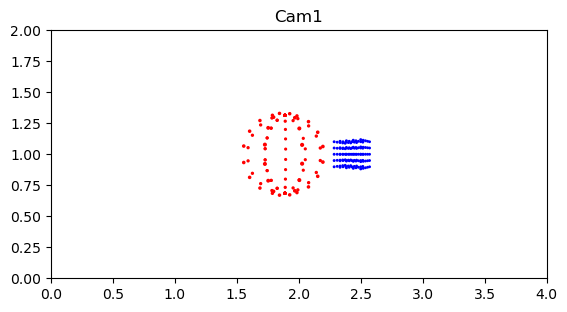

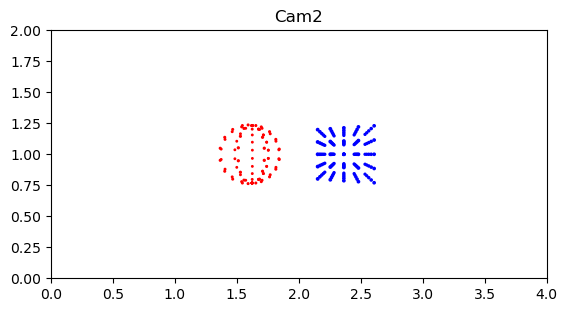

In [5]:
# example data: sphere 
px, py, pz = 4.5, 1, 1
data1 = np.array([[np.cos(theta)*np.sin(phi)+px, np.sin(theta)*np.sin(phi)+py, np.cos(phi)+pz] 
                 for theta in np.linspace(0, 2*np.pi, 10)
                 for phi in np.linspace(0, np.pi, 10)])
# example data: cube
px, py, pz = 4, -2, 1
t_ = np.linspace(-0.5, 0.5, 5)
x_, y_, z_ = t_ + px, t_ + py, t_ + pz
x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
data2 = np.c_[x.ravel(), y.ravel(), z.ravel()]

# create a point cloud object
pts = PointCloud()
pts.add_data([data1, 'red'])
pts.add_data([data2, 'blue'])

# create two cameras
camera1 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1")
camera2 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 1]), "Cam2")

camera1.capture(pts)
camera2.capture(pts)

# add some other objects
line1 = Segment(camera1.center, camera2.center, color='black')
pt1 = Point(camera1.center, color='red')

FIG = plot_all([camera1, camera2, pts, line1, pt1], world=True)


# -----------------------------
# Save the 3D plot as png file just for demonstration purpose on GitHub
#FIG.write_image("fig1.png")
#%run display_image.py
# -----------------------------

camera1.show_image()
camera2.show_image()

## Camera anatomy 
### Finding the camera center
Camera projection matrix: $P=KR[I|-C]$ <br>
Method 1: Camera center $C$ is in the null space of $P$ such that $PC=0$. <br>
Method 2: Directly derive the solution from the projection matrix. <br>
Method 3: Using the following formula<br>
$x = det([p_2, p_3, p_4]), y = -det([p_1, p_3, p_4]), \\z = det([p_1, p_2, p_4]), t = -det([p_1, p_2, p_3])$



In [6]:
import scipy 

# method 1
def find_center1(P):
    homo_c = scipy.linalg.null_space(P).ravel()
    return homo2eucl(homo_c)

# method 2
def find_center2(P):
    M = P[:, :3]
    m = P[:, -1]
    center = -np.linalg.inv(M) @ m
    return center

# method 3
def find_center3(P):
    x = np.linalg.det(np.stack([camera1.P[:, 1], camera1.P[:, 2], camera1.P[:, 3]]))
    y = -np.linalg.det(np.stack([camera1.P[:, 0], camera1.P[:, 2], camera1.P[:, 3]]))
    z = np.linalg.det(np.stack([camera1.P[:, 0], camera1.P[:, 1], camera1.P[:, 3]]))
    t = -np.linalg.det(np.stack([camera1.P[:, 0], camera1.P[:, 1], camera1.P[:, 2]]))
    homo_c = np.array([x, y, z, t])
    return homo2eucl(homo_c)

print("Method 1 :", np.allclose(find_center1(camera1.P), camera1.center))
print("Method 2 :", np.allclose(find_center2(camera1.P), camera1.center))
print("Method 3 :", np.allclose(find_center3(camera1.P), camera1.center))

Method 1 : True
Method 2 : True
Method 3 : True


### Finding the camera orientation and internal parameters

In [7]:
def gram_schmidt(A):
    # Gram-Schmidt only works for full rank matrix
    # if not full rank, use numpy qr decomposition
    if np.linalg.matrix_rank(A) < A.shape[1]:
        print("call numpy qr")
        Q, _ = np.linalg.qr(A)
        return Q
    Q = []
    for i in range(A.shape[1]):
        u = A[:, i]
        for q in Q:
            u = u - (q @ A[:, i]) * q / (q @ q)
        Q.append(u / np.linalg.norm(u))
    return np.array(Q).T

def qr(A):
    Q = gram_schmidt(A)
    R = Q.T @ A 
    return Q, R 

def rq(A):
    Q = gram_schmidt(A.T[:, ::-1])[:, ::-1].T
    R = A @ Q.T
    return R, Q

K, R = rq(camera1.P[:, :-1])
print("Camera calibration matrix (K) :", np.allclose(K, camera1.K))
print("Camera pose (R) :", np.allclose(R, camera1.R))

Camera calibration matrix (K) : True
Camera pose (R) : True


## Computation of the Camera Matrix P
Assume we have a number of point correspondences $\mathbf{X_i} \leftrightarrow \left( {\begin{array}{c} x_i \\ y_i \\ w_i\end{array}} \right)$
$$
\left[ {\begin{array}{ccc}
    0^T & -w_i\mathbf{X}_i^T & y_i\mathbf{X}_i^T \\
    w_i\mathbf{X}_i^T & 0^T & -x_i\mathbf{X}_i^T \\
     & . & \\
     & . & \\
     & . & \\
\end{array}}\right]
\left( {\begin{array}{c} P_1 \\ P_2 \\ P_3 \end{array}}\right) = 0
$$

### Solve $Ap = 0$ subject to  $\lVert p \rVert = 1$ <br>
When the system is over-determined, the problem becomes minimizing $\lVert Ap \rVert$ subject to  $\lVert p \rVert = 1$. <br>
$$
\begin{aligned}
&L(p, \lambda) = p^T A^T A p + \lambda (1 - p^T p) \\
&\frac{\partial L(p, \lambda)}{\partial p} = 2 A^T A p - 2 \lambda p = 0 \\
&\Rightarrow A^T A p = \lambda p \\
&\Rightarrow p = \text{Eigenvector of } A^T A \\
&\Rightarrow p \in \{ v_i| [v_1, v_2, ...]  = V \} \ \text{, where}\ A = U \Sigma V^T 
\end{aligned}
$$
Now we know that $p$ is a singular vector of $A$. Now evaluate the loss function
$$ 
\lVert Ap \rVert = \lVert Av_i \rVert=\sqrt{(Av_i)^T Av_i} = \sqrt{(\sigma_i u_i)^T \sigma_i u_i} = \sqrt{\sigma_i^2} = \sigma_i 
$$
Thus, to minimize this term, we can just choose $p$ to be the singular vector of the smallest singular value of $A$. $\ \ \ \ \square$
<br><br>
Alternative solution can be minimizing $\frac{\lVert Ap\rVert}{\lVert p \rVert}$ directly with no constraint, which leads to the same result. The derivation is omitted here, but can be found in Gil Strang's Linear Algebra textbook.

 

In [8]:
X = eucl2homo(camera1.world_pts)
x = eucl2homo(camera1.image_pts)

def find_P(X, x):
    A = np.zeros((X.shape[0], 2*12))
    for i in range(A.shape[0]):
        A[i, 4:8] = -x[i, 2] * X[i, :]
        A[i, 8:12] = x[i, 1] * X[i, :]
        A[i, 12:16] = x[i, 2] * X[i, :]
        A[i, 20:24] = -x[i, 0] * X[i, :]
    A = A.reshape(int(A.shape[0] * 2), int(A.shape[1] / 2))
    U, sig, Vt = np.linalg.svd(A)
    Pi = Vt[-1, :]

    P = np.stack([Pi[0:4], Pi[4:8], Pi[8:12]])
    P /= P[-1, -1]
    return P

def compareP(P_cam, P_estimate, X, x):
    normalize = lambda P: P/P[-1, -1]
    print("Compare P1 and P2 after rescaled :", np.allclose(normalize(P_cam), normalize(P_estimate)))
    x_estimate = X @ P_estimate.T
    x = homo2eucl(x)
    x_estimate = homo2eucl(x_estimate)
    print("Compare P1 and P2 by point transformation result:", np.allclose(x, x_estimate))

P = find_P(X, x)
compareP(camera1.P, P, X, x)

Compare P1 and P2 after rescaled : True
Compare P1 and P2 by point transformation result: True


# Epipolar Geometry



## About Pseudoinverse 
Pseudoinverse is part of the solution of $Ax=b$. When the system is over- or underdetermined, $\hat{x}=A^{+} b$, where $A^{+}$ is the pseudoinverse of $A$.

### Case 1: Underdetermined system $Ax=b$ <br>
Since $b \in C(A)$, x has infinite solutions. Thus, the problem becomes minimizing $\lVert x \rVert$ s.t. $Ax=b$.
$$
\begin{aligned}
minimize & \ \lVert x \rVert s.t. Ax=b \\
= minimize & \ \frac{x^T x}{2} \ s.t. \ Ax = b \\
\Rightarrow L(x, \lambda) &= \frac{x^T x}{2} + \lambda^T(b-Ax) \\
\Rightarrow \frac{\partial L(x, \lambda)}{\partial x} &= x - A^T \lambda \Rightarrow x = A^T \lambda \\
\Rightarrow L(\lambda) &= \frac{1}{2} \lambda^T A A^T \lambda + \lambda^T b- \lambda^T A A^T \lambda \\
&= -\frac{1}{2} \lambda^T A A^T \lambda + \lambda^T b \\
\frac{\partial L(\lambda)}{\partial \lambda} &= -A A^T \lambda + b = 0 \\
\Rightarrow b &= A A^T \lambda \\
\Rightarrow \lambda &= (A A^T)^{-1} b  \\
\Rightarrow \hat{x} &= A^T(A A^T)^{-1} b 
\end{aligned}
$$
(Note that $A$ : $m\times n$, m<n. Thus, $A A^T$ is a full rank matrix)

To establish a connection with SVD, let's consider, without loss of generality, matrix $A$ as a $3\times4$ matrix, identical to the camera projection matrix and<br>
$
\Sigma_{3\times3}=
\left[ {\begin{array}{ccc}
    \sigma_1 &  &  \\
    & \sigma_2 &  \\
     &  & \sigma_3 \\
\end{array}}\right], \
\Sigma_{3\times4}=
\left[ {\begin{array}{ccc}
    \sigma_1 &  & & 0 \\
    & \sigma_2 & & 0 \\
     &  & \sigma_3 & 0 \\
\end{array}}\right], \
\Sigma_{4\times3}=
\left[ {\begin{array}{ccc}
    \sigma_1 &  &  \\
    & \sigma_2 &  \\
     &  & \sigma_3 \\
    0 &0 & 0\\
\end{array}}\right], \
\Sigma_{4\times3}^{-1}=
\left[ {\begin{array}{ccc}
    \sigma_1^{-1} &  &  \\
    & \sigma_2^{-1} &  \\
     &  & \sigma_3^{-1} \\
    0 &0 & 0\\
\end{array}}\right], \
U = \left[ u_1 \ u_2 \ u_3\right], \
V = \left[ v_1 \ v_2 \ v_3 \ v_4\right], \
V_{4\times3} = \left[ v_1 \ v_2 \ v_3\right]
$

$$ 
\begin{aligned}
A &= U \Sigma_{3\times 4} V^T \\
A^T &= V \Sigma_{3\times 4}^T U^T \\
A A^T &= U \Sigma_{3\times 4} \Sigma_{3\times 4}^T U^T \\
&= U \Sigma_{3\times 3}^2 U^T \\ \\
A^T(A A^T)^{-1} &= V \Sigma_{3\times 4}^T U^T U (\Sigma_{3\times 3}^2)^{-1} U^T \\
&= V \Sigma_{4\times 3}^{-1} U^T \\
&= V_{4 \times 3} \Sigma_{3 \times 3}^{-1} U^T \\
&= A^{+} \\
\\
\Rightarrow \hat{x} &= A^{+} b  \ \ \ \ \square
\end{aligned}
$$


### Case 2: Overdetermined system $Ax=b$ <br>
When the system is overdetermined, the problem becomes just minimizing $(b - Ax)^T (b - Ax)$ with no constraint.
$$
\begin{aligned}
&\frac{\partial}{\partial x} (b - Ax)^T (b - Ax) = -2A^T(b-Ax)=0 \\
&\Rightarrow A^T A x = A^T b \\
&\Rightarrow x = (A^T A)^{-1} A^T b 
\end{aligned}
$$

In a similar manner,
$$
\begin{aligned}
A^T A &= V \Sigma_{m\times n}^T U^T U \Sigma_{m\times n} V^T \\
&= V \Sigma_{m\times n}^T \Sigma_{m\times n} V^T \\
&= V \mathbf{\Sigma_{n\times n}}^2 V^T \\
\\
(A^T A)^{-1} A^T &= V (\Sigma_{n\times n}^2)^{-1} V^T V \Sigma_{m\times n}^T U^T \\
&= V (\Sigma_{n\times n}^2)^{-1} \Sigma_{m\times n}^T U^T \\
&= V \Sigma_{n\times m}^{-1}  U^T \\
&= V \Sigma_{n\times m}^{-1}  U^T \\
&= V \Sigma_{n\times n}^{-1}  U_{m\times n}^T \\
&= A^{+} \\
\\
\Rightarrow \hat{x} &= A^{+} b  \ \ \ \ \square
\end{aligned}
$$




## The fundemental matrix $F$

The epipolar line is the projection in the second image of the ray from $X$ to the center of the first camera.
$$ 
    l^\prime = e^\prime \times x^\prime = [e^\prime]_\times x^\prime
$$
And the fundemental matrix $F$ is a mapping that maps a 2D image point to its corresponding epipolar line on the other image plane.
$$
    F: x \mapsto l^\prime
$$

### Geometric Derivation
The ray: $X(\lambda) = P^+ x + \lambda C$, where $P P^+ = I$. <br>
$X(\lambda=0)=P^+ x$, $X(\lambda = \infty) = C$. <br>
(Note that $P^+ x \neq X$, $P^+ x$ is a random point on the line $\overleftrightarrow{XC}$)

Then, project $P^+ x$ and C onto the second image plane by multiplying $P^\prime$. <br>
The epipolar line $l^\prime$: 
$$
\begin{aligned}
    l^\prime &= P^\prime C \times P^\prime P^+ x \\
    &= [e^\prime]_\times P^\prime P^+ x \\
    &= Fx \\
    \Rightarrow F &= [e^\prime]_\times P^\prime P^+ \\
\end{aligned}
$$ 
Also,  
$$
\begin{aligned}
    l^\prime &= Fx \\
    \Rightarrow x^{\prime T} l^\prime &= 0 \\
    \Rightarrow x^{\prime T} F x &= 0 
\end{aligned}
$$ 

### Summary of fundemental matrix properties
- Point correspondence <br>
$x^\prime F x = 0$

- Epipolar lines <br>
$l\prime = Fx$ is the epipolar line corresponding to $x$. <br>
$l = F^T x^\prime$ is the epipolar line corresponding to $x^\prime$.

- Epipoles <br>
$Fe = 0$. <br>
$F^T e^\prime = 0$.

- Computation from camera matrices $P$, $P^\prime$ <br>
$F = [e^\prime]_\times P^\prime P^+$, where $e^\prime=P^\prime C$, with $PC=0$.

In [9]:
# plot a point(2D) on a camera image plane(3D)
class CameraPoint(Point):

    def __init__(self, pts, camera, color='black', size=2):
        self.R = camera.R
        self.center = camera.center
        self.K = camera.K
        world_pts = self.img2world(pts)
        super().__init__(world_pts, color, size)

        self.data = world_pts

    # transform image points to world coordinates
    # (transformed points are on the image plane in 3D world, not 3D reconstruction)
    def img2world(self, x):
        xcam = np.linalg.inv(self.K) @ eucl2homo(x) # image frame to camera frame
        xworld = xcam @ self.R + self.center # R^T*xcam + C
        return xworld
    
    def get_fig_data(self):
        return super().get_fig_data()
    
class CameraLine(Line):
    
    def __init__(self, l, camera, color='black', opacity=1):
        # save the camera information
        self.R = camera.R
        self.center = camera.center 
        self.K = camera.K
        ximg1, ximg2 = self.find_two_img_pts(l)
        
        start = self.img2world(ximg1)
        end = self.img2world(ximg2)
        super().__init__(start, end, color, opacity)

    # transform image points to world coordinates
    # (transformed points are on the image plane in 3D world, not 3D reconstruction)
    def img2world(self, x):
        xcam =  eucl2homo(x) @ np.linalg.inv(self.K).T # image frame to camera frame
        xworld = xcam @ self.R + self.center # R^T*xcam + C
        return xworld
    
    # find two image points that l^T x = 0
    def find_two_img_pts(self, l):
        # let the two points be [x, 0, 1] and [0, y, 1]
        ximg1 = np.array([-l[2]/l[0], 0])
        ximg2 = np.array([0, -l[2]/l[1]])
        return ximg1, ximg2
    
    def get_fig_data(self):
        return super().get_fig_data()
    
def vec2skew(x):
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ])

def find_F(C, P0, P1):
    C = eucl2homo(C)
    return vec2skew(P1 @ C) @ P1 @ np.linalg.pinv(P0)

# given two 2D points, print the line equation
def line_equation(pt1, pt2):
    m = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    k = (pt1[1] * pt2[0] - pt2[1] * pt1[0]) / (pt2[0] - pt1[0])
    print(f'line equation : {m:.2f}x + {k:.2f} = y')

# point size
size = 5

# create two cameras
cameraA = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1", show_frame=False)
cameraB = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 1]), "Cam2", show_frame=False)

# test point 
X = np.array([5, 2, 1.6])

ptX = PointCloud(size=size)
ptX.add_data([X, 'red']) # will not be plotted 
cameraA.capture(ptX)
cameraB.capture(ptX)

F = find_F(cameraA.center, cameraA.P, cameraB.P)

# =========== x -> l ====================
l = F @ eucl2homo(cameraA.image_pts[0])
# =======================================
    
epiline = CameraLine(l, cameraB, color='red')
line1 = Segment(cameraA.center, cameraB.center)
line2 = Segment(cameraA.center, X, 'red')
line3 = Segment(cameraB.center, X)

# epipole and projected point on second image plane 
epipole1 = homo2eucl(cameraA.P @ eucl2homo(cameraB.center))
epipole2 = homo2eucl(cameraB.P @ eucl2homo(cameraA.center))
Xproj1 = homo2eucl(cameraA.P @ eucl2homo(X))
Xproj2 = homo2eucl(cameraB.P @ eucl2homo(X))
pt_epipole1 = CameraPoint(epipole1, cameraA, size=size)
pt_epipole2 = CameraPoint(epipole2, cameraB, size=size)
pt_Xproj1 = CameraPoint(Xproj1, cameraA, size=size)
pt_Xproj2 = CameraPoint(Xproj2, cameraB, size=size)

# verify fundemental matrix properties 

print("Verify fundemental matrix properties")
print("-"*40)
print("point correspondance :", np.allclose(eucl2homo(cameraB.image_pts[0])[None, :] @ F @ eucl2homo(cameraA.image_pts[0]), 0))
print("l\'=Fx :", "demonstrate using the graph.")
print("Fe = 0 and F^T e\' = 0 :", np.allclose(F @ eucl2homo(epipole1), 0), ",", np.allclose(F.T @ eucl2homo(epipole2), 0))
print("-"*40)

# add name tags
text = Text([pt_epipole1.data, pt_epipole2.data, pt_Xproj1.data, pt_Xproj2.data, X, 2*pt_Xproj2.data-pt_epipole2.data], 
            ['e', 'e\'', 'x', 'x\'', 'X', 'l\''])

FIG = plot_all([cameraA, cameraB, ptX, epiline, line1, line2, line3, pt_epipole1, pt_epipole2, pt_Xproj1, pt_Xproj2, text], world=True)


    

Verify fundemental matrix properties
----------------------------------------
point correspondance : True
l'=Fx : demonstrate using the graph.
Fe = 0 and F^T e' = 0 : True , True
----------------------------------------


In [10]:
# create two cameras
camera3 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1")
camera4 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 2]), "Cam2")

# define observation data
pt1 = np.array([4, 0, 1])

# save to PointCloud and captured by the camera
pts = PointCloud()
pts.add_data([pt1, 'red'])
camera3.capture(pts)
camera4.capture(pts)

X = camera4.camera_pts[0]
Xprime = camera3.camera_pts[0]
T = camera3.pose.T @ (camera4.center - camera3.center)
R = camera3.pose.T @ camera4.pose

# X' = RX + T
print('X\' = RX + T')
print(np.allclose(Xprime, R @ X + T))

# T x X' = T x RX + T x T
print('T x X\' = T x RX + T x T')
print(np.allclose(np.cross(T, Xprime), np.cross(T, R @ X)))

# X'.(T x X') = X'.(T x RX) = 0
print('X\'.(T x X\') = X\'.(T x RX) = 0')
print(np.allclose(np.dot(Xprime, np.cross(T, Xprime)), np.dot(Xprime, np.cross(T, R @ X))))

X' = RX + T
True
T x X' = T x RX + T x T
True
X'.(T x X') = X'.(T x RX) = 0
True


### Essential Matrix <br>
$
X^\prime \cdot (T\times RX)$ = $X^\prime \cdot (T_x RX)\\
$
Let 
$
E = T_xR \\
X^{\prime T} EX = 0
$

In [11]:
# essential matrix
E = skew(T) @ R
print("X\'.T @ E @ X = 0")
print(np.allclose(Xprime.T @ E @ X, 0))

X'.T @ E @ X = 0
True


$p^\prime E p = 0 \\$
Remeber to "uncalibrate" the points on image plane (substract $[\frac{width}{2}, \frac{height}{2}, 0]$) so that the vector can be parallel to the vector in camera coordinate plane.

### Reference
- R. Hartley, A. Zisserman Multiple View Geometry in Computer Vision 2nd Ed., Cambridge Univ. Press, 2004